In [27]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd

import pandas as pd
from pandas.errors import SettingWithCopyWarning
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr


from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
from shapely import wkt

import datetime
from datetime import date
import traceback

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
# SettingWithCopyWarning


In [28]:
### 2020 fire-name cheat sheet

fires = gpd.read_file('/projects/shared-buckets/ashiklom/WesternUS/files_for_paper/sample_segments_2020_.geojson')

In [63]:
fires.Name.unique()

array(['PORPHYRY', 'ANTELOPE', 'S-4 SHELDON', 'EAST FORK', 'BLUE CREEK',
       'HABANERO', 'POEVILLE ROAD', 'TAFT', 'FIRE GULCH',
       'AUGUST COMPLEX', 'ADAMSON CA', 'AIRPORT', 'CREWS', 'BULLFROG',
       'TRAP', 'DOLAN', 'DENNIS HILL', 'DALTON', 'BIG HOLLOW', 'SNIDER',
       'HILL', 'MEDIO', 'HOLSER', 'OIL', 'HILLS', 'BLACK PINE',
       'PINE GULCH', 'WHITE SAGE', 'MAGPIE ROCK', 'GOOD', 'WALKER',
       'ENCINOS', 'PALMER', 'WILLIAM', 'ESPINOSA', 'JUNCTION RANCH',
       'CHIKAMIN', 'MARION - MRO', 'BERNARD', 'CENTER CREEK TRAIL',
       'CZU AUG LIGHTNING', 'LOUSE CREEK', 'GRIZZLY CREEK', 'ROAD 11',
       'CUB', 'HIDDEN', 'SLINK', 'SNOW', 'EAST CANYON', 'MAHOGANY',
       'GRIFFIN', 'CAMERON PEAK', 'STREETER', 'GASS FLATS',
       'HUBBARDS GAP', 'MOC', 'WILLOW', 'UNNAMED', 'BUCK',
       'SCU LIGHTNING COMPLEX', 'CENTRAL', 'MONUMENT', 'SHAFTER',
       'BEAVER', 'MULLEN', 'SARPY', 'BIGHORN', 'FAWN CREEK',
       'EAST DESERT', 'DEVIL', 'FROG 0657 RS', 'HEJ RX 0982 PR', 'DOUBL

In [68]:
#fires.FireID[fires.Name == 'BOBCAT'].unique()
fires.FireID[fires.Name == 'DOLAN'].unique()
fires.FireID[fires.Name == 'WINDY'].unique() # DOnt have it? 
fires.FireID[fires.Name == 'ZOGG'].unique()



array(['F14147'], dtype=object)

In [30]:
## Load up spread days from Tess' stuff. 

manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")
manyfr.columns
manyfr["func_failed"].unique()
debug = manyfr[(manyfr["func_failed"] == 'load_large_fire/get_gpm')  ]
manyfr = manyfr[(manyfr["func_failed"] != 'load_large_fire/get_gpm')  ]

manyfr = manyfr[manyfr.n_pixels.notna()]
manyfr = manyfr.sort_values(by = ["t"])

manyfr.geometry = manyfr.geometry.apply(wkt.loads)
manyfr = gpd.GeoDataFrame(manyfr, geometry = "geometry")

### Static Source filtering
dirextdata = '/projects/shared-buckets/gsfc_landslides/FEDSinput/'
source = "VIIRS_Global_flaring_d.7_slope_0.029353_2017_web_v1.csv"


global_flaring = gpd.read_file(os.path.join(dirextdata,'static_sources', source))
global_flaring = global_flaring.drop_duplicates()
global_flaring = global_flaring[0:(len(global_flaring.id_key_2017) - 1)]

global_flaring = gpd.GeoDataFrame(global_flaring, geometry=gpd.points_from_xy(global_flaring.Longitude, global_flaring.Latitude))

global_flaring["buffer_geometry"] = global_flaring.buffer(0.2)

global_flaring = global_flaring.set_geometry(col = "buffer_geometry")
global_flaring.geometry

with_sources = len(manyfr.fireID.unique())
joinfr = gpd.sjoin(manyfr, global_flaring, how='left', op='within')
joinfr = joinfr[joinfr.geometry_right.isna()]

manyfr = manyfr[manyfr.fireID.isin(joinfr.fireID.unique())]

/tmp/ipykernel_1377/101754459.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,11,12,16,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
## Read in Tina's stuff

import glob

goes_fires = glob.glob("/projects/Tina_goes/summary/*")

In [32]:
goes_fires

['/projects/Tina_goes/summary/Red_Salmon_Complex_2020.csv',
 '/projects/Tina_goes/summary/July_Complex_2020.csv',
 '/projects/Tina_goes/summary/Bobcat_2020.csv',
 '/projects/Tina_goes/summary/Zogg_2020.csv',
 '/projects/Tina_goes/summary/Kincade_2019.csv',
 '/projects/Tina_goes/summary/W-5_Cold_Springs_2020.csv',
 '/projects/Tina_goes/summary/SCU_Lightning_Complex_2020.csv',
 '/projects/Tina_goes/summary/Tamarack_2021.csv',
 '/projects/Tina_goes/summary/McFarland_2021.csv',
 '/projects/Tina_goes/summary/Antelope_2021.csv',
 '/projects/Tina_goes/summary/LNU_Lightning_Complex_2020.csv',
 '/projects/Tina_goes/summary/SQF_Complex_2020.csv',
 '/projects/Tina_goes/summary/KNP_Complex_2021.csv',
 '/projects/Tina_goes/summary/Dixie_2021.csv',
 '/projects/Tina_goes/summary/Monument_2021.csv',
 '/projects/Tina_goes/summary/CZU_Lightning_Complex_2020.csv',
 '/projects/Tina_goes/summary/Windy_2021.csv',
 '/projects/Tina_goes/summary/River_Complex_2021.csv',
 '/projects/Tina_goes/summary/Slater_and

In [85]:
fr_sum = pd.read_csv('/projects/Tina_goes/summary/Zogg_2020.csv')

fr_stat = pd.read_csv('/projects/Tina_goes/fire_stats/Zogg_2020_FEDSComp.csv')

ourfr = manyfr[manyfr.fireID == 14147]
ourfr.t = ourfr.t.astype("datetime64[ns]") + datetime.timedelta(hours = 1, minutes=30)

ignition = min(ourfr.t.astype("datetime64[ns]"))

fr_sum["t"] = np.nan
for i,ts in enumerate(fr_sum.timeStep):
    fr_sum["t"][i] = ignition + datetime.timedelta(hours = ts)

(array([18534., 18536., 18540., 18544., 18548., 18552., 18556.]),
 [Text(18534.0, 0, '2020-09-29'),
  Text(18536.0, 0, '2020-10-01'),
  Text(18540.0, 0, '2020-10-05'),
  Text(18544.0, 0, '2020-10-09'),
  Text(18548.0, 0, '2020-10-13'),
  Text(18552.0, 0, '2020-10-17'),
  Text(18556.0, 0, '2020-10-21')])

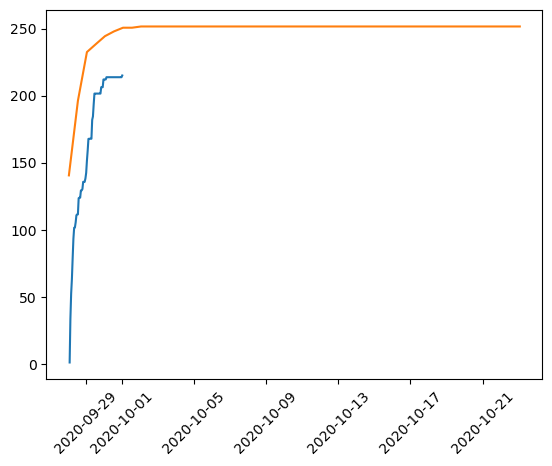

In [86]:
plt.plot(fr_sum.t.astype("datetime64[ns]"), fr_sum.area_km2.astype("float"))
plt.plot(ourfr.t.astype("datetime64[ns]"), ourfr.farea.astype("float"))
plt.xticks(rotation = 45)

(array([18510., 18514., 18518., 18522., 18526., 18530.]),
 [Text(18510.0, 0, '2020-09-05'),
  Text(18514.0, 0, '2020-09-09'),
  Text(18518.0, 0, '2020-09-13'),
  Text(18522.0, 0, '2020-09-17'),
  Text(18526.0, 0, '2020-09-21'),
  Text(18530.0, 0, '2020-09-25')])

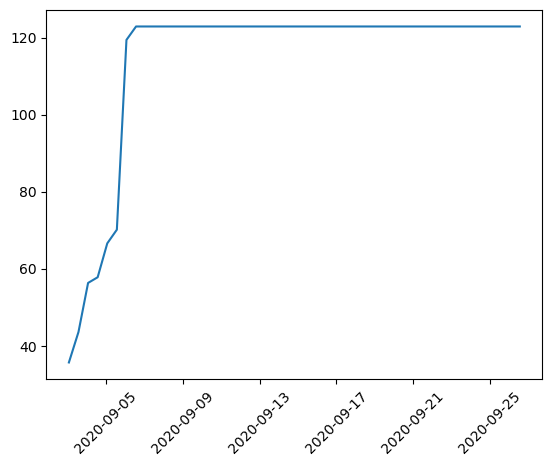

In [61]:
plt.plot(ourfr.t, ourfr.farea)
plt.xticks(rotation = 45)

In [51]:
fr_sum

,timeStep,area_km2,perim_km,rfline_km,cfline5_km,cfline10_km,cfline25_km,cfline50_km,cfline75_km,cfline90_km,dArea_km2,maefspread_kmh,awefspread_kmh
0,1,3.644,9.603,9.603,9.603,9.603,9.603,9.603,9.603,9.603,3.644,2.265,1.281
1,2,7.766,11.372,10.119,11.372,11.372,11.372,11.372,9.100,5.079,4.122,0.690,0.429
2,3,11.298,13.261,6.926,13.261,13.261,13.261,13.261,11.028,2.770,3.532,1.024,0.349
3,4,15.945,15.776,4.836,15.776,15.776,15.776,15.776,14.488,7.400,4.647,1.164,0.671
4,5,17.499,16.775,5.115,16.775,16.775,16.775,16.775,15.422,4.444,1.554,0.809,0.321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,429,565.384,129.117,5.192,11.332,10.237,7.702,3.151,2.760,0.395,3.501,1.375,0.605
429,430,565.384,129.117,5.192,4.262,3.080,7.702,3.151,2.760,0.395,0.000,0.000,0.000
430,431,565.384,129.117,5.192,6.834,5.788,1.449,3.151,2.760,0.395,0.000,0.000,0.000
431,432,565.384,129.117,5.192,6.428,4.765,1.449,3.151,2.760,0.395,0.000,0.000,0.000
